In [21]:
import os.path as osp

import torch
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# load the Cora dataset
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.10, num_test=0.20, neg_sampling_ratio = 1.0,
                  is_undirected=True, add_negative_train_samples=False),
])
dataset = Planetoid('./data/Planetoid', name='Cora')
dataset.num_features

1433

In [14]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [15]:
data = transform(data)

In [16]:
# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.
train_data, val_data, test_data = data
print(train_data)
print(val_data)
print(test_data)

Data(x=[2708, 1433], edge_index=[2, 7392], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[3696], edge_label_index=[2, 3696])
Data(x=[2708, 1433], edge_index=[2, 7392], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[1054], edge_label_index=[2, 1054])
Data(x=[2708, 1433], edge_index=[2, 8446], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[2110], edge_label_index=[2, 2110])


In [17]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        #return the indices of a non-zero element
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [22]:
model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [19]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1))

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())



Epoch: 001, Loss: 0.6930, Val: 0.6599, Test: 0.6826
Epoch: 002, Loss: 0.6836, Val: 0.6537, Test: 0.6759
Epoch: 003, Loss: 0.7059, Val: 0.6625, Test: 0.6858
Epoch: 004, Loss: 0.6783, Val: 0.6871, Test: 0.7073
Epoch: 005, Loss: 0.6851, Val: 0.7045, Test: 0.7256
Epoch: 006, Loss: 0.6878, Val: 0.6890, Test: 0.7126
Epoch: 007, Loss: 0.6876, Val: 0.6633, Test: 0.6875
Epoch: 008, Loss: 0.6850, Val: 0.6512, Test: 0.6739
Epoch: 009, Loss: 0.6797, Val: 0.6466, Test: 0.6683
Epoch: 010, Loss: 0.6752, Val: 0.6448, Test: 0.6651
Epoch: 011, Loss: 0.6770, Val: 0.6443, Test: 0.6618
Epoch: 012, Loss: 0.6733, Val: 0.6462, Test: 0.6594
Epoch: 013, Loss: 0.6661, Val: 0.6517, Test: 0.6622
Epoch: 014, Loss: 0.6625, Val: 0.6605, Test: 0.6703
Epoch: 015, Loss: 0.6592, Val: 0.6685, Test: 0.6790
Epoch: 016, Loss: 0.6532, Val: 0.6717, Test: 0.6826
Epoch: 017, Loss: 0.6442, Val: 0.6756, Test: 0.6856
Epoch: 018, Loss: 0.6396, Val: 0.6965, Test: 0.7050
Epoch: 019, Loss: 0.6272, Val: 0.7382, Test: 0.7440
Epoch: 020, 

Epoch: 161, Loss: 0.4245, Val: 0.9012, Test: 0.9044
Epoch: 162, Loss: 0.4243, Val: 0.9011, Test: 0.9044
Epoch: 163, Loss: 0.4185, Val: 0.9013, Test: 0.9039
Epoch: 164, Loss: 0.4179, Val: 0.9024, Test: 0.9036
Epoch: 165, Loss: 0.4255, Val: 0.9031, Test: 0.9041
Epoch: 166, Loss: 0.4199, Val: 0.9029, Test: 0.9045
Epoch: 167, Loss: 0.4200, Val: 0.9012, Test: 0.9039
Epoch: 168, Loss: 0.4171, Val: 0.9008, Test: 0.9037
Epoch: 169, Loss: 0.4193, Val: 0.9028, Test: 0.9044
Epoch: 170, Loss: 0.4206, Val: 0.9041, Test: 0.9044
Epoch: 171, Loss: 0.4196, Val: 0.9042, Test: 0.9040
Epoch: 172, Loss: 0.4205, Val: 0.9026, Test: 0.9037
Epoch: 173, Loss: 0.4151, Val: 0.9021, Test: 0.9036
Epoch: 174, Loss: 0.4169, Val: 0.9049, Test: 0.9044
Epoch: 175, Loss: 0.4234, Val: 0.9065, Test: 0.9043
Epoch: 176, Loss: 0.4122, Val: 0.9046, Test: 0.9035
Epoch: 177, Loss: 0.4176, Val: 0.9025, Test: 0.9031
Epoch: 178, Loss: 0.4205, Val: 0.9026, Test: 0.9037
Epoch: 179, Loss: 0.4155, Val: 0.9045, Test: 0.9041
Epoch: 180, 

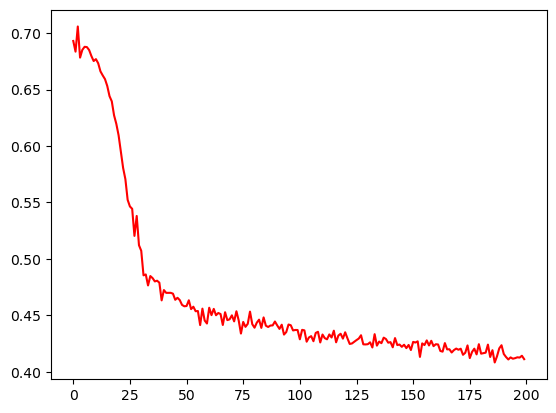

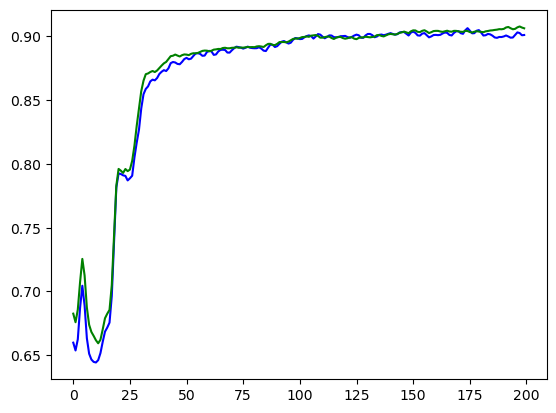

In [23]:
loss_values, val_auc_values, test_auc_values, = [], [], []

best_val_auc = final_test_auc = 0
for epoch in range(1, 201):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    loss_values.append(loss.item())
    val_auc_values.append(val_auc)
    test_auc_values.append(test_auc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, 'f'Test: {test_auc:.4f}')


plt.plot(loss_values, 'r',)
plt.show()
plt.plot(val_auc_values, 'b', test_auc_values, 'g' )
plt.show()

In [7]:
z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

In [9]:
final_edge_index.shape

torch.Size([2, 3312102])